In [116]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier

## https://scikit-learn.org/stable/auto_examples/datasets/plot_random_dataset.html

In [17]:
def PNN_fit(X_train,X_test,y_train,y_test,sigma):
    # n_classes = len(my_data.groupby('<class_name_space>''))
    ## TODO: improve the number of classes value
    n_classes = max(y_train)
    prob = np.zeros((X_test.shape[0],max(y_train))) 
#     print(prob.shape)
    # X_test = np.array([[0.5,0.5],[0.8,0.2],[0.4,0.7]])
    # prob = np.zeros((X_test.shape[0],max(y)[0]))

    ## loop through all the X_test data (unclassified points)
    for point in range(0,X_test.shape[0]):
        x_test = X_test[point,:] 
    #     print(x_test)
        ## loop through i-th class
        for i in range(1,n_classes+1):
            X_i = X_train[np.where(y_train == i)[0],:]
            summ = 0.
            ## loop through j-th element of the i-th class
            for j in range(0,X_i.shape[0]):
                ## norm L2 (sum of squares)
                norm = 0.
                ## loop through k-th feature
                for k in range(0,X_i.shape[1]):
                    ## TODO: covariance form X*M*X'
                    norm = norm + (X_i[j,k]-x_test[k])*(X_i[j,k]-x_test[k])  
                ## Summation of Gaussians
                summ = summ + np.exp((-1/2)*(1/(2*sigma**2))*norm)
            ## Average of Parzen Window (normalization term)
            summ = summ/X_i.shape[0]
            ## Decision boundary
            prob[point, (i-1)] = summ
    
    return prob

def PNN_classify(prob):
    # argmax of each 
    y_prob = np.asarray([max(prob[i,:]) for i in range(0,prob.shape[0])])
    y_bar = np.asarray([np.where(prob[ix,:] == max(prob[ix,:]))[0][0]+1 for ix in range(0,prob.shape[0])])
    
    return y_bar

def PNN_score(y_bar,y_test):
    return accuracy_score(y_test, y_bar)

In [121]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]
classifiers = [GaussianProcessClassifier(1.0 * RBF(1.0)),PNN(1),KNeighborsClassifier(3)]

names = ["Gaussian Process","Probabilistic neural network","Nearest Neighbors"]

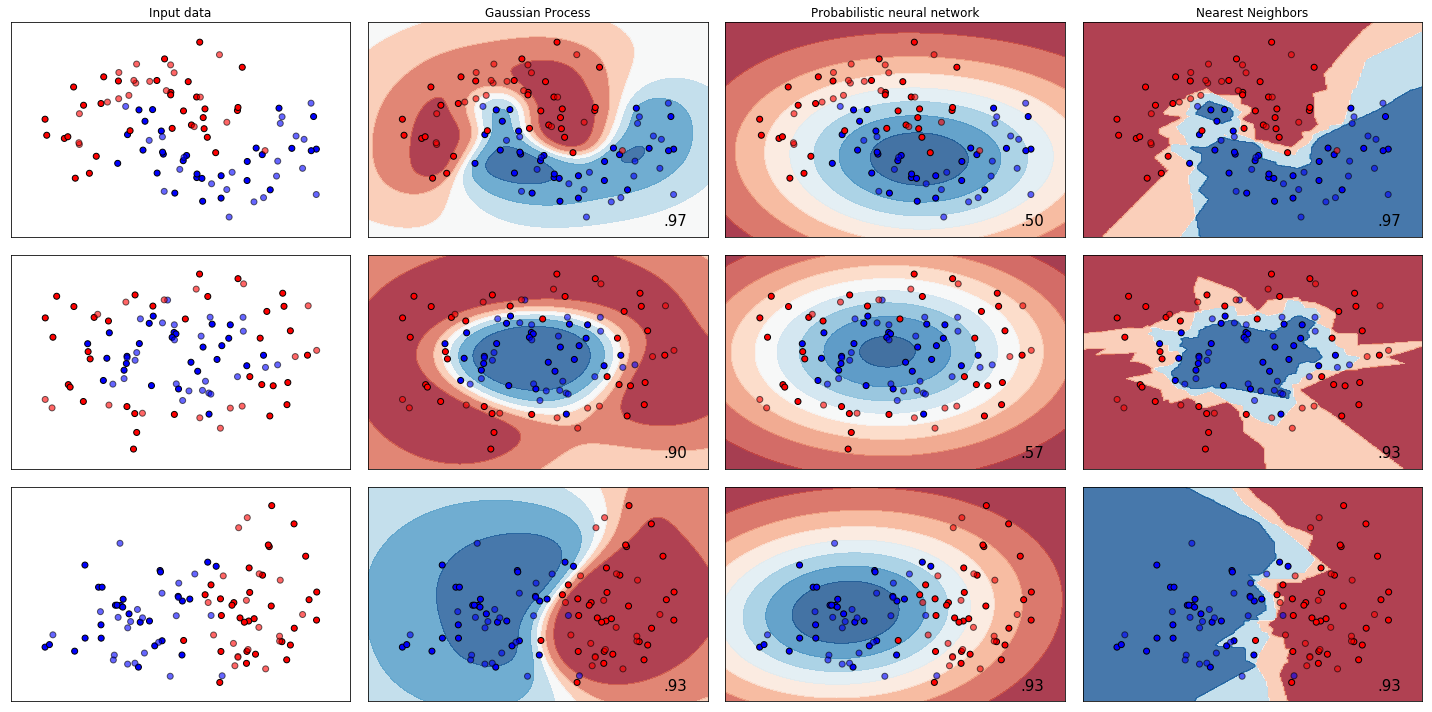

In [122]:
figure = plt.figure(figsize=(20, 10))
i = 1
h = .02 # step size in the mesh

# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
   # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)
    y_train = y_train+1
    y_test = y_test+1

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        if hasattr(clf, "pnn_gambi"):
            clf.fit(X_train,X_test,y_train)
        else:
            clf.fit(X_train, y_train)
            
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
#             print("here")
            ## probability class 1
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
#             print(Z.shape)

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

In [75]:
prob = PNN_fit(X_train,X_test,y_train,y_test,sigma = 0.1)
y_bar =  PNN_classify(prob)
PNN_score(y_bar,y_test)

0.925

In [76]:
type(prob)

numpy.ndarray

In [77]:
clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].shape

(70680,)

In [45]:
xx.ravel().shape

(70680,)

In [35]:
np.c_[xx.ravel(), yy.ravel()].shape

(70680, 2)

In [108]:
class PNN:
    
    pnn_gambi = True
    
    def __init__(self, sigma):
        self.sigma = sigma

    def __repr__(self):
        return 'Sigma(%r)' % self.sigma
    
    def fit(self,X_train,X_test,y_train):
        # n_classes = len(my_data.groupby('<class_name_space>''))
        ## TODO: improve the number of classes value
        sigma = self.sigma
        n_classes = max(y_train)
        prob = np.zeros((X_test.shape[0],max(y_train))) 
    #     print(prob.shape)
        # X_test = np.array([[0.5,0.5],[0.8,0.2],[0.4,0.7]])
        # prob = np.zeros((X_test.shape[0],max(y)[0]))

        ## loop through all the X_test data (unclassified points)
        for point in range(0,X_test.shape[0]):
            x_test = X_test[point,:] 
        #     print(x_test)
            ## loop through i-th class
            for i in range(1,n_classes+1):
                X_i = X_train[np.where(y_train == i)[0],:]
                summ = 0.
                ## loop through j-th element of the i-th class
                for j in range(0,X_i.shape[0]):
                    ## norm L2 (sum of squares)
                    norm = 0.
                    ## loop through k-th feature
                    for k in range(0,X_i.shape[1]):
                        ## TODO: covariance form X*M*X'
                        norm = norm + (X_i[j,k]-x_test[k])*(X_i[j,k]-x_test[k])  
                    ## Summation of Gaussians
                    summ = summ + np.exp((-1/2)*(1/(2*sigma**2))*norm)
                ## Average of Parzen Window (normalization term)
                summ = summ/X_i.shape[0]
                ## Decision boundary
                prob[point, (i-1)] = summ
                self.prob = prob
                self.X_train = X_train
                self.y_train = y_train
                self.X_test = X_test
                
    def score(self, X_test,y_test):
        y_prob = np.asarray([max(self.prob[i,:]) for i in range(0,self.prob.shape[0])])
        self.y_bar = np.asarray([np.where(prob[ix,:] == max(prob[ix,:]))[0][0]+1 for ix in range(0,prob.shape[0])])
        acc_score = accuracy_score(y_test, self.y_bar)
        
        return acc_score

    def predict(self):
        ## TODO: 
        # argmax of each 
#         prob = self.prob
        y_prob = np.asarray([max(self.prob[i,:]) for i in range(0,self.prob.shape[0])])
        self.y_bar = np.asarray([np.where(prob[ix,:] == max(prob[ix,:]))[0][0]+1 for ix in range(0,prob.shape[0])])
#         self.y_bar = y_bar
#         return self.y_bar
        
    
    def predict_proba(self,X_range):
        self.fit(self.X_train,X_range,self.y_train)
        
        return self.prob

In [103]:
classifiers = [PNN(0.1)]
classifiers[0].fit(X_train,X_test,y_train)
classifiers[0].score(y_test,y_test)

0.925

In [109]:
classifiers[0].predict_proba(np.c_[xx.ravel(), yy.ravel()])

array([[3.64530491e-99, 3.11465260e-27],
       [4.46840159e-98, 5.08540462e-27],
       [5.36889313e-97, 8.13949505e-27],
       ...,
       [4.66348183e-18, 1.09575587e-89],
       [1.57467775e-18, 1.55391399e-90],
       [5.25844181e-19, 2.16626535e-91]])

In [106]:
if hasattr(classifiers[0], "pnn_gambi"):
    print("here")

here
